# Liberal Democrat constituency-level general election results

The purpose of this notebook is to determine the distribution of constituency-level results achieved by the Liberal Democrats in recent General Elections. I am particularly interested in calculating the rank order position in each constituency, the percentage of votes gained, and the number of votes required for the Liberal Democrats to win the seat at the following election. 

The 2019 General Election, while resulting in a reduced presence in Parliament, created a number of strong second party Lib Dem results that laid the foundations for the growth of first party results in 2024. Conversely, the 2024 election seems to have brought about the opposite result: a very small number of good second party finishes. Little analysis has been done however on the shifting balance between the number of seats in second, third and fourth place (or lower). Similarly, there is little available analysis on the strength of the party's position in those seats. The Liberal Democrats have more seats in fourth place than at any time since their electoral collapse in 2015. But how steep is the challenge in those seats, and how does that compare against equivalent seats in previous years?

To help me create this notebook, I have used ChatGPT for the purposes of 1) interpreting error messages, and 2) to help with the syntax not covered in either Everything Counts or Data Science courses, in particular: a) using np.where() to conditionally substitute values in a column  b) for using lambda to lookup the values in a column, and c) more advanced charting, such as labelled stacked bar charts or multiple histogram subplots.

## Library Imports

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data wrangling - Function creation

In [189]:
def wrangle(YY):
    ''' 
    Since 2015, the House of Commons library has published data containing General Election results per constituency. 
    The data are made available in csv files with a consistent file naming convention, and with consistent column names.
    The data cannot be downloaded directly via a URL, so this function presupposes that the user has downloaded the files and partyd in a folder called data.
    The function takes the final two digits of the year as an argument, and enters them into the filepath using an f-string.
    Since we only want to take the top five national parties plus the SNP and Plaid Cymru, it will take one of UKIP, The Brexit Party or Reform UK according to the year selected.
    The function then discards constituencies in Northern Ireland, which are contested by a different set of parties entirely.
    It also discards all columns other than the constituency name, first party, second party, and numeric results of the vote for the selected parties.
    Because the results columns contain numbers that contain commas, Python treats them as non-numeric data, so the function converts them into integers.
    So that validity checks can be easily run, the function creates an 'All Others' column that contains the value of all votes cast for parties other than those included.
    It then creates a set of columns containing the results for each party (and 'All Others') expressed as a percentage of the valid votes cast.
    
    '''

    df = pd.read_csv(f"data/HoC-GE20{YY}-results-by-constituency.csv") # opens the csv using the YY argument to complete the filepath


    # determine which far right party to include based on the year selected:
    if YY < 19:
        Far_Right = 'UKIP'
    elif YY == 19:
        Far_Right = 'BRX'
    else:
        Far_Right = 'RUK'
    
    df = df[df['Region name'] != 'Northern Ireland'] # removes constituencies in Northern Ireland

    df = df[df['First party'] != 'Spk'] # removes the constituency won by the Speaker (which is by convention not contested)
    

    # Remove all columns apart from those required:
    df = df[['Constituency name', 'First party', 'Second party', 'Valid votes', 'Con', 'Lab', 'LD', Far_Right, 'Green', 'SNP', 'PC']]


    # Insert underscores in party of spaces in column names:
    df.columns = df.columns.str.replace(' ', '_')
    

    # Add a column containing the year:
    df.insert(0, 'Year', f"20{YY}") 
    

    # Reformat the data in the columns containing the number of votes cast so that Python can treat the data as numeric:
    votes_columns = ['Valid_votes', 'Con', 'Lab', 'LD', Far_Right, 'Green', 'SNP', 'PC'] # creates a list variable for the columns to simplify the code
    

    # Create an 'Others' column    
    results_columns = votes_columns[1:] # create a list of columns containing the votes per party, excluding the 'Valid votes' column

    df['Others'] = df['Valid_votes'] - df[results_columns].sum(axis=1) # constructs an 'Others' column so we can ensure that the total votes cast sum to the correct number

    results_columns.append('Others') # add the new column to the list of results columns


    # Since parties grouped under 'Others' occasionally come first or second, update the 'First party' and 'Second party' columns accordingly, using np.where() code provided by ChatGPT:
    df['First_party'] = np.where(
      df['First_party'].isin(results_columns),
      df['First_party'],  # Keep the value if it's valid
     'Others'             # Replace with 'Others' if not valid
    )
    
    df['Second_party'] = np.where(
      df['Second_party'].isin(results_columns),
      df['Second_party'],  # Keep the value if it's valid
     'Others'             # Replace with 'Others' if not valid
    )


    # generate a set of columns containing the votes per party as a % of the valid votes cast, and store their names in a list:
    percent_columns = []

    for column in results_columns:
        df[f"{column}_%"] = df[column]/df['Valid_votes']*100
        percent_columns.append(f"{column}_%") # adds new columns to a list so we can run validity checks on these columns
        votes_columns.append(f"{column}_%") # also add them to the earlier votes_columns list, for the same purpose


    # generate columns containing Boolean validity checks on the resulting data:
    df['Percent_check'] = abs(100 - df[percent_columns].sum(axis = 1)) < 0.001 # checks that the percentages sum to a number close to 1

    print(df['Percent_check'].value_counts()) # print the number of True and False values to ascertain whether percentages correctly calculated

    df['Positive_check'] = (df[votes_columns] > 0).any(axis=1) # checks that all vote values are positive

    print(df['Positive_check'].value_counts()) # print the number of True and False values to ascertain whether all numeric values are positive

    # Create a column 'LD position' to store categorical assignment of constituences based on Lib Dem position in the results 
    df.insert(4, 'LD_position', df[results_columns].rank(axis=1, ascending=False)['LD']) # Create column between 'Second party' and 'Valid votes'
    df['LD_position'] = np.where( 
        df['LD_position'] == 1, '1st', # Change numeric value 1 to string value '1st'
        np.where(
            df['LD_position'] == 2, '2nd', # Change numeric value 2 to string value '2nd'
            np.where(
                df['LD_position'] == 3, '3rd', # Change numeric value 3 to string value '3rd'
                '4th or worse'  # Otherwise, replace value with string '4th or worse'
                )
            )
        )

    # Add new columns showing the number of votes won by the first and second place parties, using lambda code provided by ChatGPT:
    df.insert(3, 'First_party_votes', df.apply(lambda row: row[row['First_party']], axis=1))
    df.insert(5, 'Second_party_votes', df.apply(lambda row: row[row['Second_party']], axis=1))

    # Add new columns showing the percentage of votes won by the first and second place parties:
    df.insert(4, 'First_party_%', df['First_party_votes']/df['Valid_votes']*100)
    df.insert(7, 'Second_party_%', df['Second_party_votes']/df['Valid_votes']*100)

    # Add a new column showing the difference between the winning party's vote and the Lib Dems' vote, in percentage terms
    # Unless the Lib Dems are the winning party, in which case it should show a negative number measuring the difference between the Lib Dem vote and the second place vote           
    df.insert(9, 'LD_diff_%', '')
    
    df['LD_diff_%'] = np.where(
        df['First_party'] == 'LD', 
        df['LD_%'] - df['Second_party_%'],
        df['LD_%'] - df['First_party_%']
        )
    
    print(df.shape)  # print the number of columns and rows to enable visual checking for errors
    
    print(df.columns) # print the columns created to enable visual checking for errors

    print(df.describe()) # print the default descriptive statistics for each column to enable visual checking for errors 

    return df

## Data wrangling - Output validation

Having created the above function, we now simply need to apply it to each dataset and ascertain that the validity check columns have produced True in every row, and visually check the .columns and .describe() outputs for any unexpected values.

In [190]:
GE2010 = wrangle(10)

Percent_check
True    631
Name: count, dtype: int64
Positive_check
True    631
Name: count, dtype: int64
(631, 29)
Index(['Year', 'Constituency_name', 'First_party', 'First_party_votes',
       'First_party_%', 'Second_party', 'Second_party_votes', 'Second_party_%',
       'LD_position', 'LD_diff_%', 'Valid_votes', 'Con', 'Lab', 'LD', 'UKIP',
       'Green', 'SNP', 'PC', 'Others', 'Con_%', 'Lab_%', 'LD_%', 'UKIP_%',
       'Green_%', 'SNP_%', 'PC_%', 'Others_%', 'Percent_check',
       'Positive_check'],
      dtype='object')
       First_party_votes  First_party_%  Second_party_votes  Second_party_%  \
count         631.000000     631.000000          631.000000      631.000000   
mean        21667.660856      47.087348        13206.640254       28.532539   
std          4792.330010       7.044061         4186.160664        7.212971   
min          6723.000000      29.357953         2061.000000        9.406495   
25%         17990.500000      41.740075        10319.000000       23.1176

In [191]:
GE2015 = wrangle(15)

Percent_check
True    631
Name: count, dtype: int64
Positive_check
True    631
Name: count, dtype: int64
(631, 29)
Index(['Year', 'Constituency_name', 'First_party', 'First_party_votes',
       'First_party_%', 'Second_party', 'Second_party_votes', 'Second_party_%',
       'LD_position', 'LD_diff_%', 'Valid_votes', 'Con', 'Lab', 'LD', 'UKIP',
       'Green', 'SNP', 'PC', 'Others', 'Con_%', 'Lab_%', 'LD_%', 'UKIP_%',
       'Green_%', 'SNP_%', 'PC_%', 'Others_%', 'Percent_check',
       'Positive_check'],
      dtype='object')
       First_party_votes  First_party_%  Second_party_votes  Second_party_%  \
count         631.000000     631.000000          631.000000      631.000000   
mean        23766.893819      49.976324        12172.264659       25.750039   
std          5213.694330       7.493106         4044.227242        7.751285   
min          8662.000000      30.956214         3445.000000        8.469206   
25%         19850.000000      43.963380         9037.500000       19.3637

In [192]:
GE2017 = wrangle(17)

Percent_check
True    631
Name: count, dtype: int64
Positive_check
True    631
Name: count, dtype: int64
(631, 29)
Index(['Year', 'Constituency_name', 'First_party', 'First_party_votes',
       'First_party_%', 'Second_party', 'Second_party_votes', 'Second_party_%',
       'LD_position', 'LD_diff_%', 'Valid_votes', 'Con', 'Lab', 'LD', 'UKIP',
       'Green', 'SNP', 'PC', 'Others', 'Con_%', 'Lab_%', 'LD_%', 'UKIP_%',
       'Green_%', 'SNP_%', 'PC_%', 'Others_%', 'Percent_check',
       'Positive_check'],
      dtype='object')
       First_party_votes  First_party_%  Second_party_votes  Second_party_%  \
count         631.000000     631.000000          631.000000      631.000000   
mean        27824.874802      55.847443        15738.378764       31.866021   
std          6488.832855       9.308433         4602.704138        8.516588   
min          6013.000000      29.227752         3355.000000        7.300938   
25%         23581.500000      49.671469        12669.500000       25.8869

In [193]:
GE2019 = wrangle(19)

Percent_check
True    631
Name: count, dtype: int64
Positive_check
True    631
Name: count, dtype: int64
(631, 29)
Index(['Year', 'Constituency_name', 'First_party', 'First_party_votes',
       'First_party_%', 'Second_party', 'Second_party_votes', 'Second_party_%',
       'LD_position', 'LD_diff_%', 'Valid_votes', 'Con', 'Lab', 'LD', 'BRX',
       'Green', 'SNP', 'PC', 'Others', 'Con_%', 'Lab_%', 'LD_%', 'BRX_%',
       'Green_%', 'SNP_%', 'PC_%', 'Others_%', 'Percent_check',
       'Positive_check'],
      dtype='object')
       First_party_votes  First_party_%  Second_party_votes  Second_party_%  \
count         631.000000     631.000000          631.000000      631.000000   
mean        27120.218700      54.593311        14459.554675       29.487187   
std          6578.896196       8.693520         4575.579353        8.462158   
min          6531.000000      34.647095         4018.000000        7.817917   
25%         21964.000000      48.174556        11279.500000       22.773765

In [194]:
GE2024 = wrangle(24)

Percent_check
True    631
Name: count, dtype: int64
Positive_check
True    631
Name: count, dtype: int64
(631, 29)
Index(['Year', 'Constituency_name', 'First_party', 'First_party_votes',
       'First_party_%', 'Second_party', 'Second_party_votes', 'Second_party_%',
       'LD_position', 'LD_diff_%', 'Valid_votes', 'Con', 'Lab', 'LD', 'RUK',
       'Green', 'SNP', 'PC', 'Others', 'Con_%', 'Lab_%', 'LD_%', 'RUK_%',
       'Green_%', 'SNP_%', 'PC_%', 'Others_%', 'Percent_check',
       'Positive_check'],
      dtype='object')
       First_party_votes  First_party_%  Second_party_votes  Second_party_%  \
count          631.00000     631.000000          631.000000      631.000000   
mean         18718.07607      42.399515        11724.936609       26.211794   
std           3583.34449       7.200862         3311.773649        5.832713   
min           6692.00000      26.721552         2856.000000       10.492225   
25%          16176.00000      36.733174         9192.000000       22.155180

## Data wrangling - Dataframe concatenation & secondary validation

Having standardised the five datasets, we now need to append them into a single master dataset for further analysis.

In [195]:
df_master = pd.concat([GE2010, GE2015, GE2017, GE2019, GE2024], axis=0, ignore_index=True)
df_master.shape

(3155, 33)

In [196]:
df_master.columns

Index(['Year', 'Constituency_name', 'First_party', 'First_party_votes',
       'First_party_%', 'Second_party', 'Second_party_votes', 'Second_party_%',
       'LD_position', 'LD_diff_%', 'Valid_votes', 'Con', 'Lab', 'LD', 'UKIP',
       'Green', 'SNP', 'PC', 'Others', 'Con_%', 'Lab_%', 'LD_%', 'UKIP_%',
       'Green_%', 'SNP_%', 'PC_%', 'Others_%', 'Percent_check',
       'Positive_check', 'BRX', 'BRX_%', 'RUK', 'RUK_%'],
      dtype='object')

In [197]:
df_master.head()

,Year,Constituency_name,First_party,First_party_votes,First_party_%,Second_party,Second_party_votes,Second_party_%,LD_position,LD_diff_%,...,Green_%,SNP_%,PC_%,Others_%,Percent_check,Positive_check,BRX,BRX_%,RUK,RUK_%
0,2010,Aberavon,Lab,16073,51.918729,LD,5034,16.260740,2nd,-35.657988,...,0.000000,0.000000,7.099942,8.892693,True,True,NaN,NaN,NaN,NaN
1,2010,Aberconwy,Con,10734,35.820597,Lab,7336,24.481079,3rd,-16.512047,...,0.000000,0.000000,17.823533,0.457185,True,True,NaN,NaN,NaN,NaN
2,2010,Aberdeen North,Lab,16746,44.417920,SNP,8385,22.240789,3rd,-25.848121,...,0.000000,22.240789,0.000000,2.395162,True,True,NaN,NaN,NaN,NaN
3,2010,Aberdeen South,Lab,15722,36.533903,LD,12216,28.386857,2nd,-8.147047,...,0.959706,11.855742,0.000000,1.549937,True,True,NaN,NaN,NaN,NaN
4,2010,Airdrie and Shotts,Lab,20849,58.157829,SNP,8441,23.545985,4th or worse,-50.073921,...,0.000000,23.545985,0.000000,1.472844,True,True,NaN,NaN,NaN,NaN


In [198]:
df_master.tail()

,Year,Constituency_name,First_party,First_party_votes,First_party_%,Second_party,Second_party_votes,Second_party_%,LD_position,LD_diff_%,...,Green_%,SNP_%,PC_%,Others_%,Percent_check,Positive_check,BRX,BRX_%,RUK,RUK_%
3150,2024,Wythenshawe and Sale East,Lab,20596,52.632117,RUK,5986,15.296944,4th or worse,-47.559542,...,10.561689,0.0,0.000000,2.657671,True,True,NaN,NaN,5986.0,15.296944
3151,2024,Yeovil,LD,23765,48.547557,Con,11497,23.486272,1st,25.061285,...,4.908890,0.0,0.000000,1.242033,True,True,NaN,NaN,7677.0,15.682710
3152,2024,Ynys Môn,PC,10590,32.456786,Con,9953,30.504475,4th or worse,-31.111315,...,1.851171,0.0,32.456786,0.612970,True,True,NaN,NaN,3223.0,9.878019
3153,2024,York Central,Lab,24537,56.637352,Con,5383,12.425271,4th or worse,-49.594903,...,11.968239,0.0,0.000000,1.029476,True,True,NaN,NaN,4721.0,10.897214
3154,2024,York Outer,Lab,23161,45.319532,Con,13770,26.943999,4th or worse,-34.565413,...,4.328259,0.0,0.000000,1.085978,True,True,NaN,NaN,5912.0,11.568113


In [199]:
df_master.describe()

,First_party_votes,First_party_%,Second_party_votes,Second_party_%,LD_diff_%,Valid_votes,Con,Lab,LD,UKIP,...,LD_%,UKIP_%,Green_%,SNP_%,PC_%,Others_%,BRX,BRX_%,RUK,RUK_%
count,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,3155.000000,1893.000000,...,3155.000000,1893.000000,3155.000000,3155.000000,3155.000000,3155.000000,631.000000,631.000000,631.000000,631.000000
mean,23819.544849,49.980788,13460.354992,28.369516,-37.053855,47353.784786,17881.581616,16104.429477,5971.342948,2827.295298,...,12.229405,6.046894,3.164151,3.395495,0.739261,1.957712,1021.009509,2.396310,6525.530903,14.866006
std,6415.633756,9.391653,4422.319663,7.936357,18.244741,7279.567553,9419.834177,7708.253990,6087.500538,2996.610296,...,11.816414,6.455775,3.967032,11.271670,4.013216,4.118338,1665.609822,4.146213,2976.370191,7.131361
min,6013.000000,26.721552,2061.000000,7.300938,-84.216887,13528.000000,0.000000,1158.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,18779.000000,43.058949,10300.500000,22.419602,-48.686251,42398.000000,10085.500000,10651.500000,1712.500000,799.000000,...,3.917726,1.727883,1.040143,0.000000,0.000000,0.000000,0.000000,0.000000,4400.500000,9.545260
50%,23147.000000,49.448864,13133.000000,28.404195,-40.308169,47679.000000,16923.000000,15974.000000,3550.000000,1648.000000,...,7.285011,3.468119,2.406644,0.000000,0.000000,0.636854,0.000000,0.000000,6944.000000,15.216253
75%,28187.000000,56.174998,16290.500000,33.874401,-28.898974,52311.000000,25532.500000,20448.000000,7975.500000,4355.000000,...,16.727334,9.395016,4.196141,0.000000,0.000000,2.109360,1559.000000,3.503100,8541.000000,19.694352
max,47351.000000,85.728843,29639.000000,59.055950,51.318102,75528.000000,44683.000000,47351.000000,36166.000000,19642.000000,...,62.707690,44.431877,57.158868,61.913495,53.937368,49.283761,11233.000000,30.439260,21225.000000,46.183472


## Analysis - Distribution of Lib Dem Results by Position

News coverage of general elections tends to report the number of constituencies, or 'seats' won by each party. Looking only at this measure, we see a simple story of collapse and recovery for the Liberal Democrats.

In [200]:
# Create a dataframe containing only the first place LD results, grouped by General Election:
df_first = df_master[df_master['LD_position'] == '1st']
df_first = df_first.groupby('Year').size() # groups the data by General Election and counts how many rows are in each group
print("Number of Constituencies won by Liberal Democrats: \n", df_first)

Number of Constituencies won by Liberal Democrats: 
 Year
2010    57
2015     8
2017    12
2019    11
2024    72
dtype: int64


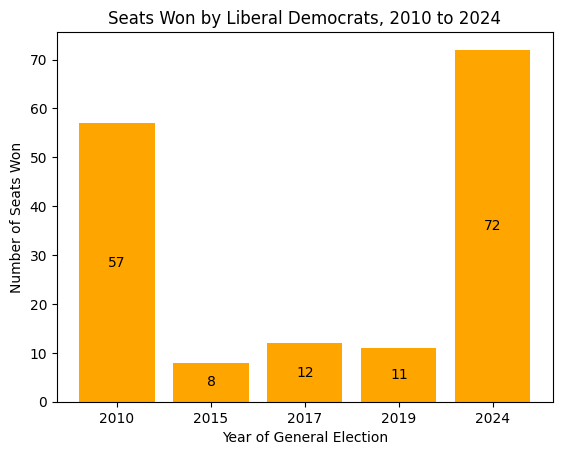

In [201]:
# Create a bar chart and data labels
bars = plt.bar(df_first.index, df_first.values, color='orange')
plt.bar_label(bars, label_type='center')

# Add title and axis labels
plt.title('Seats Won by Liberal Democrats, 2010 to 2024')
plt.xlabel('Year of General Election')
plt.ylabel('Number of Seats Won')

plt.show()

However, a more complex story emerges if we show the performance of the party in terms of the number of seats in second, third and fourth or worse. To reveal this, we first need to group the data by our two main categories of interest: the General Election in question (referred to by the year in which it was held), and the position achieved by the Lib Dems in each constituency. Having done that, we can then visualise and analyse the data.

In [202]:
# Create a dataframe containing the results grouped by General Election year and by Lib Dem position
df_grouped = df_master.groupby(['Year', 'LD_position']).size().unstack(fill_value=0) # counts the number of rows in each group
df_grouped

LD_position,1st,2nd,3rd,4th or worse
Year,,,,
2010,57,242,296,36
2015,8,63,36,524
2017,12,38,336,245
2019,11,91,342,187
2024,72,27,43,489


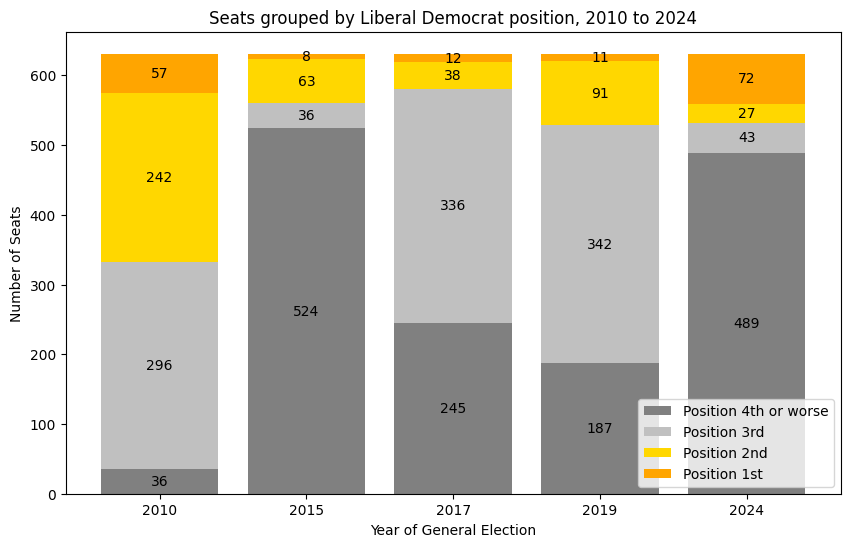

In [203]:
# Create a stacked bar chart
x = df_grouped.index
fig, ax = plt.subplots(figsize=(10, 6))
colors = ['orange', 'gold', 'silver', 'grey']

# Create stacked bars (with a little help from ChatGPT...)
bottom = None
for position, color in zip(reversed(df_grouped.columns), reversed(colors)):
    bars = ax.bar(x, df_grouped[position], bottom=bottom, label=f'Position {position}', color=color)
    bottom = (bottom if bottom is not None else 0) + df_grouped[position]
    ax.bar_label(bars, label_type='center')

# Add title and axis labels
plt.title('Seats grouped by Liberal Democrat position, 2010 to 2024')
plt.xlabel('Year of General Election')
plt.ylabel('Number of Seats')
plt.legend()

plt.show()

While the headline results may be that in 2024 the Liberal Democrats finally recovered from their 2015 general election collapse, in terms of number of seats in Parliament won, it's clear that that victory came at the cost of significant backward progress in the majority of seats. The party maintained roughly the same combined number of 1st and 2nd places between 2019 and 2024 (102 and 99, respectively), successfully converting 72% of those into first place seats in 2024 compared to 11% in 2019. However, their number of seats in fourth or worse rocketed from 187 to 489 in the same period, nearly matching the number of seats in that position in 2015. The party dropped from having 342 constituencies in third place to having only 43, the remainder all being in fourth or worse. 

What's more, the party saw the lowest number of seats in second place than at any of the previous four elections - a particularly important finding since further review of the data (not shown here) indicates that every seat won by the party in this most recent election came from first or second place. So the runway for further expansion might be limited unless the party can develop its third, fourth and worse seats up into second.

## Analysis - Vote difference by position

While there is value in looking at the number of seats grouped by position, the true measure of the strength of the party's position is how easy it would be to win or lose them at the next general election. In a seat won by the Liberal Democrats, the metric that matters is the size of the majority - that is, the difference between the % of votes cast for the Lib Dems, and the % cast for the second place party. In seats won by other parties, the inverse is the case: what matters is the difference between the % of votes case for the winning party, vs the % cast for the Liberal Democrats. In the 'wrangle()' function above, I combined these two calculations into one column ('LD_diff_%'), such that the value will be positive if the Lib Dems won the seat, and negative if they did not. The analysis below refers to this combined measure as 'vote difference'.

Plotting that value by position will demonstrate the strength and weakness of Lib Dem seats. To facilitate comparison between the years, I will plot all seats of the same position side by side, across multiple years.

### Vote difference amongst LD won seats, by year

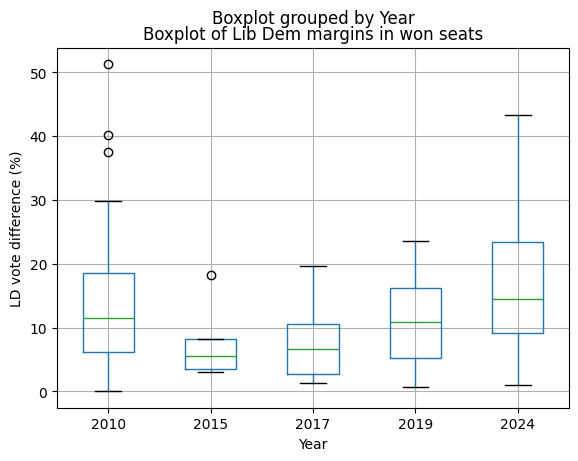

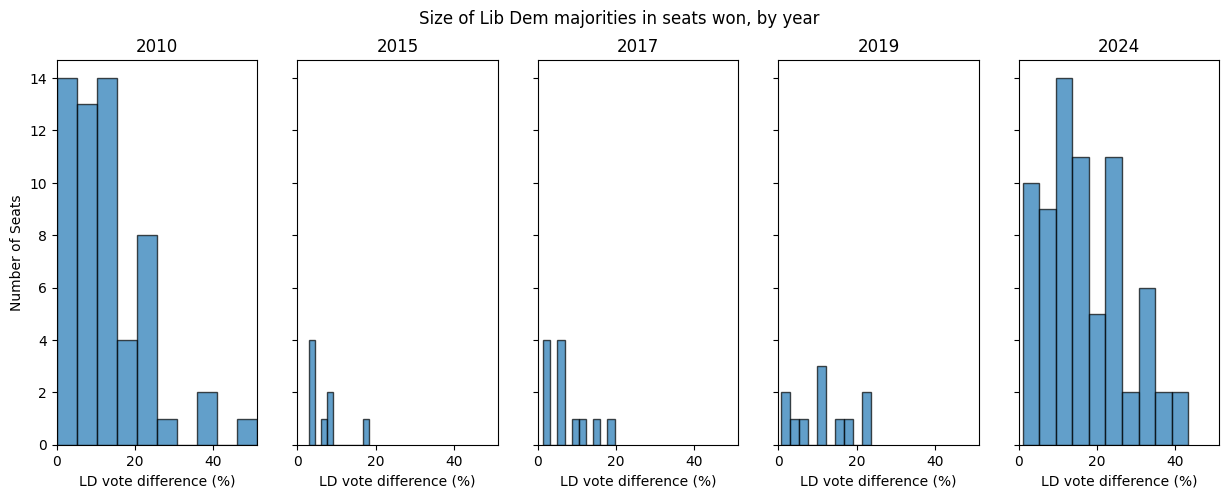

In [204]:
# Create a dataframe containing only the first place LD results
df_first = df_master[df_master['LD_position'] == '1st']

# Create a boxplot for the 'LD_diff_%' variable, grouped by year of the General Election
df_first.boxplot(column='LD_diff_%', by='Year')
plt.title('Boxplot of Lib Dem margins in won seats')
plt.ylabel('LD vote difference (%)')
plt.show()

# Determine global x-axis limits (min and max across all data)
x_min = df_first['LD_diff_%'].min()
x_max = df_first['LD_diff_%'].max()

# Create a set of histograms showing the same data
years = df_first['Year'].unique()
fig, axes = plt.subplots(1, len(years), figsize=(15, 5), sharey=True)

# Create a histogram for each year
for ax, year in zip(axes, years):
    data = df_first[df_first['Year'] == year]['LD_diff_%']
    ax.hist(data, bins=10, edgecolor='black', alpha=0.7)
    ax.set_title(f"{year}")
    ax.set_xlabel('LD vote difference (%)')
    ax.set_xlim(x_min, x_max)  # Set uniform x-axis limits
    if ax == axes[0]:
        ax.set_ylabel('Number of Seats')

# Adjust layout
plt.suptitle('Size of Lib Dem majorities in seats won, by year')
plt.show()

The 2024 General Election not only returned more first placed seats for the Liberal Democrats than any previous election, it also resulted in safer margins in those seats. The 2024 result provided a higher 25th quartile, median, and 75th quartile margin than the previous elections shown here.

### Vote difference amongst LD second placed seats, by year

Let's repeat this analysis for second place seats. The values will be negative now, showing the gap between the winning party and the Liberal Democrats.

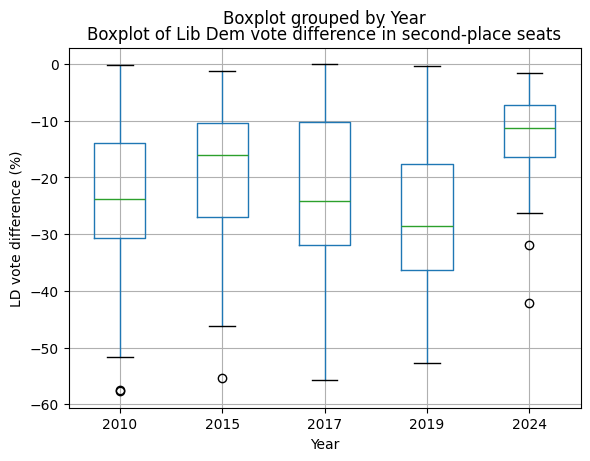

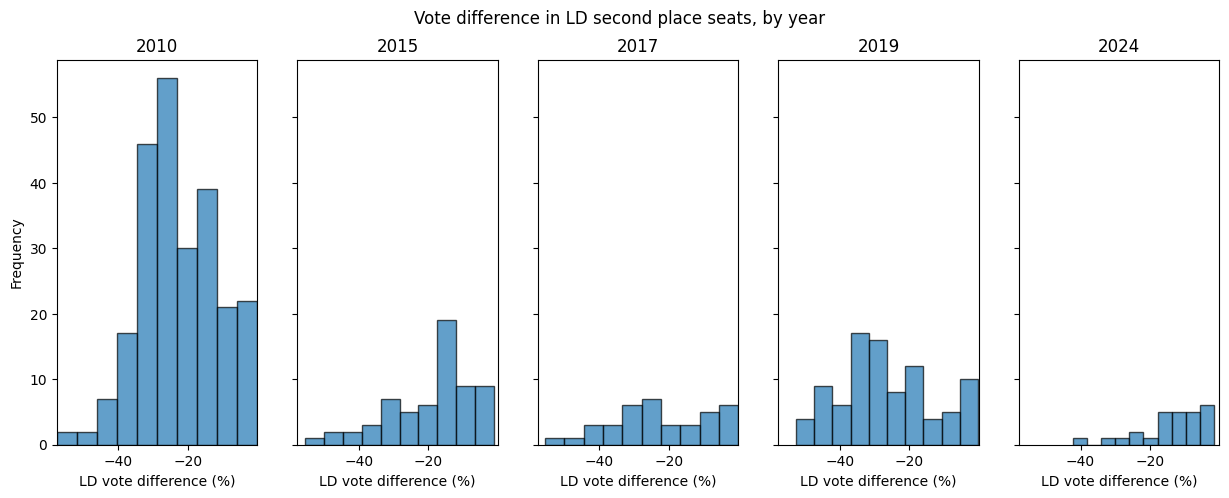

In [205]:
# Create a dataframe containing only the second place LD results
df_second = df_master[df_master['LD_position'] == '2nd']

# Create a boxplot for the 'LD_diff_%' variable, grouped by year of the General Election
df_second.boxplot(column='LD_diff_%', by='Year')
plt.title('Boxplot of Lib Dem vote difference in second-place seats')
plt.ylabel('LD vote difference (%)')
plt.show()

# Determine global x-axis limits (min and max across all data)
x_min = df_second['LD_diff_%'].min()
x_max = df_second['LD_diff_%'].max()

# Create a set of histograms showing the same data
years = df_second['Year'].unique()
fig, axes = plt.subplots(1, len(years), figsize=(15, 5), sharey=True)

# Create a histogram for each year
for ax, year in zip(axes, years):
    data = df_second[df_second['Year'] == year]['LD_diff_%']
    ax.hist(data, bins=10, edgecolor='black', alpha=0.7)
    ax.set_title(f"{year}")
    ax.set_xlabel('LD vote difference (%)')
    ax.set_xlim(x_min, x_max)  # Set uniform x-axis limits
    if ax == axes[0]:
        ax.set_ylabel("Frequency")

# Adjust layout
plt.suptitle('Vote difference in LD second place seats, by year')
plt.show()

Bearing in mind that these plots show negative values, we can clearly see that while there might be fewer second place seats now than after previous elections, the margins required to win them appears to be much smaller. Testing will be required to determine whether that apparent pattern is statistically discernible. 

However, note how the 25th percentile of the vote difference in 2024 is smaller (higher up the boxplot, because the values are negative) than the 75% percentile for each previous election. This indicates that a statistically discernible difference is likely to be observed.

We can also observe that the previous elections all showed frequency peaks at much greater vote differences: ~ -25% in 2010, ~ -15% in 2015, ~ -25% in 2017 and ~-35% in 2019, in each case peaking in the middle half of the range. The 2024 frequency data peaks right at the lowest end of the range. 

### Vote difference amongst LD third placed seats, by year

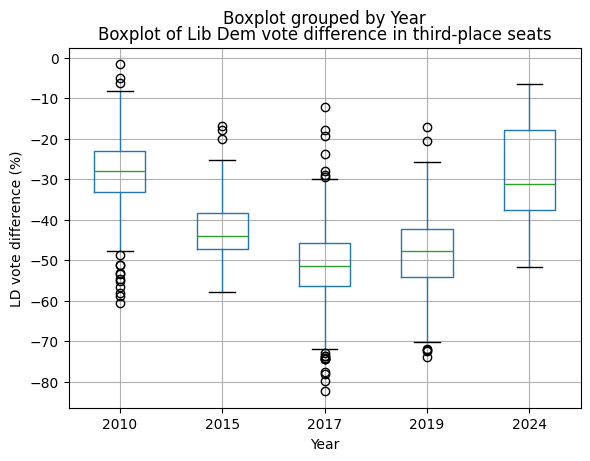

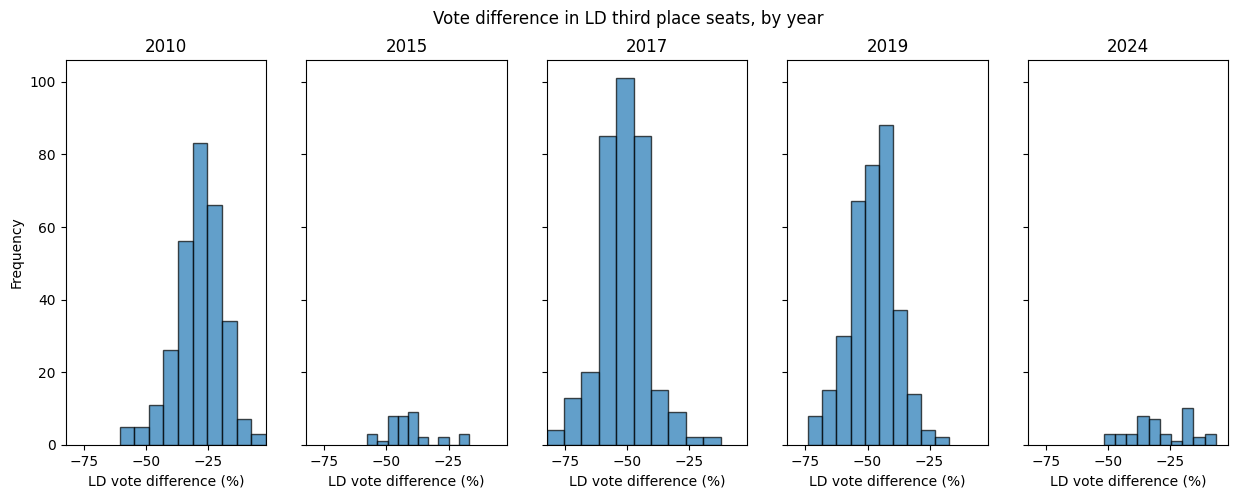

In [206]:
# Create a dataframe containing only the third place LD results
df_third = df_master[df_master['LD_position'] == '3rd']

# Create a boxplot for the 'LD_diff_%' variable, grouped by year of the General Election
df_third.boxplot(column='LD_diff_%', by='Year')
plt.title('Boxplot of Lib Dem vote difference in third-place seats')
plt.ylabel('LD vote difference (%)')
plt.show()

# Determine global x-axis limits (min and max across all data)
x_min = df_third['LD_diff_%'].min()
x_max = df_third['LD_diff_%'].max()

# Create a set of histograms showing the same data
years = df_third['Year'].unique()
fig, axes = plt.subplots(1, len(years), figsize=(15, 5), sharey=True)

# Create a histogram for each year
for ax, year in zip(axes, years):
    data = df_third[df_third['Year'] == year]['LD_diff_%']
    ax.hist(data, bins=10, edgecolor='black', alpha=0.7)
    ax.set_title(f"{year}")
    ax.set_xlabel('LD vote difference (%)')
    ax.set_xlim(x_min, x_max)  # Set uniform x-axis limits
    if ax == axes[0]:
        ax.set_ylabel("Frequency")

# Adjust layout
plt.suptitle('Vote difference in LD third place seats, by year')
plt.show()

While the third place seats in 2024 appear, prior to statistical analysis, to be easier to win than seats in an equivalent position in the previous three elections, it would also appear that they have broadly comparable vote differences to those in 2010. Statistical analysis will be required to determine whether the difference is significant. The indication however is that although the party were able to secure more first place seats than before, and fewer but much stronger second place seats, the small number of third place seats are not remarkably stronger than the party's previous high water mark in 2010, indicating that the scope for expansion beyond the 99 first and second place seats may be limited.

### Vote difference amongst seats where Lib Dems came fourth or worse, by year

Finally, let's conduct the analysis for seats where the Liberal Democrats are in fourth place or worse.

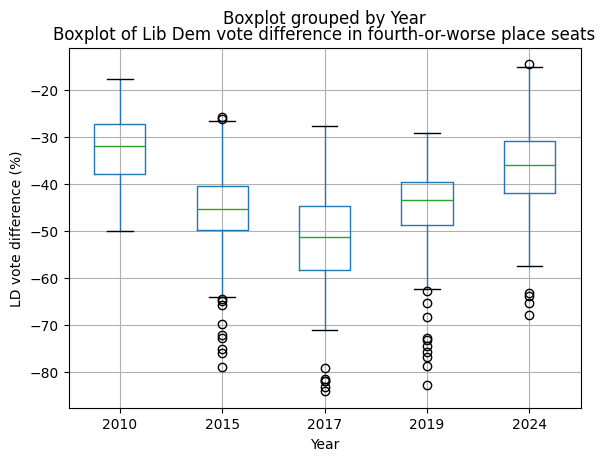

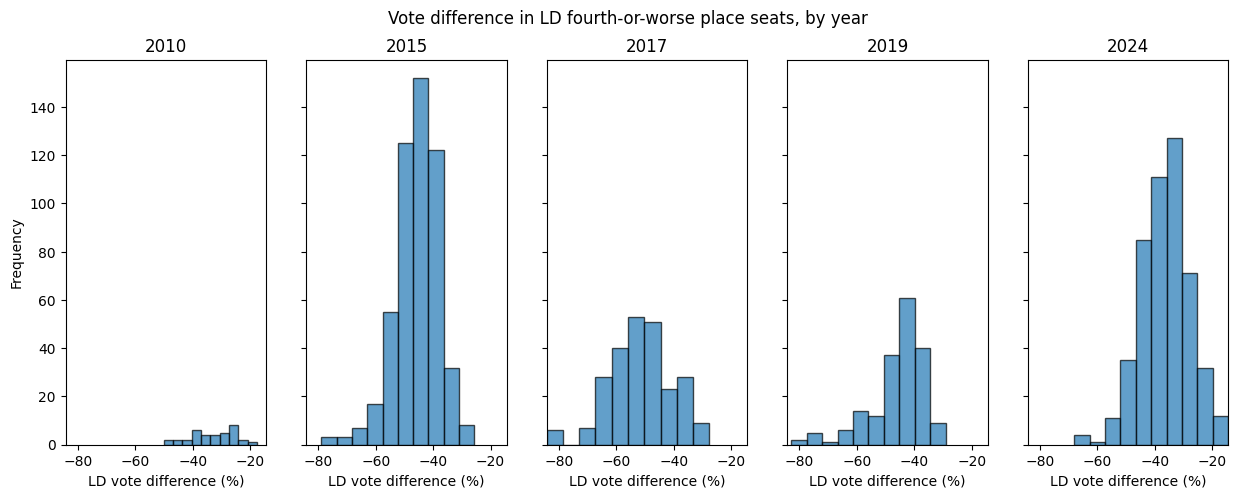

In [207]:
# Create a dataframe containing only the third place LD results
df_worse = df_master[df_master['LD_position'] == '4th or worse']

# Create a boxplot for the 'LD_diff_%' variable, grouped by year of the General Election
df_worse.boxplot(column='LD_diff_%', by='Year')
plt.title('Boxplot of Lib Dem vote difference in fourth-or-worse place seats')
plt.ylabel('LD vote difference (%)')
plt.show()

# Determine global x-axis limits (min and max across all data)
x_min = df_worse['LD_diff_%'].min()
x_max = df_worse['LD_diff_%'].max()

# Create a set of histograms showing the same data
years = df_worse['Year'].unique()
fig, axes = plt.subplots(1, len(years), figsize=(15, 5), sharey=True)

# Create a histogram for each year
for ax, year in zip(axes, years):
    data = df_worse[df_worse['Year'] == year]['LD_diff_%']
    ax.hist(data, bins=10, edgecolor='black', alpha=0.7)
    ax.set_title(f"{year}")
    ax.set_xlabel('LD vote difference (%)')
    ax.set_xlim(x_min, x_max)  # Set uniform x-axis limits
    if ax == axes[0]:
        ax.set_ylabel("Frequency")

# Adjust layout
plt.suptitle('Vote difference in LD fourth-or-worse place seats, by year')
plt.show()

Thankfully, the much greater number of seats in fourth or worse than seen in the previous three elections has not been accompanied by a collapse in vote difference between the Lib Dems and the winning party, when compared to seats in equivalent positions in previous years. For the first time since 2010, the party has had seats in fourth place or worse with a vote of difference of less than -20%. This suggests that the party might be able to repeat the advances from fourth into third seen in 2017, when the Liberal Democrats had worse vote differences in seats in this position but were able to reduce that number of seats from 2015's high water mark of 524 to 184 in 2017.

## Conclusion



While the Liberal Democrat result in 2024 did return the highest number of MPs for the party this century (and, indeed, in the party's history since it's founding in 1988), those gains came at the cost of a weakening of the party's standing in hundreds of seats, and a dramatic reduction in the number of second place seats: from 91 in 2019 to only 27 in 2024. While that occured because the party won the majority of those second constituencies, it also generates a challenge for the next election because every seat won by the party in 2024 came from first or second place.As a resut, it would appear that the scope for Lib Dem expansion beyond their current 72 seats is much more limited than it was after the 2010 election, for example, when the party had 242 seats in second place. 

Conversely, the party went from having 187 seats in fourth or worse at the previous election to having 489 such seats now - almost as bad as the party's worst result, in 2015. However, while the number of seats in fourth place may be eye-watering, there is good news: the vote differences in those seats are much smaller than they have been in the period for which data is available. Smaller, in fact, than they were in 2017 when the party lept from having 524 seats in fourth place or worse (83% of all constituencies) to having only 184 (29%). So while the pathway for further growth in first placed seats might be limited, there is a clear precedent for bringing the fourth or worse seats up to third, and potentially further.